# Download packages

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from k_means_constrained import KMeansConstrained
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph 
from scipy.sparse.linalg import expm
import scipy
from skfeature.utility import construct_W
from skfeature.function.similarity_based import lap_score
from tqdm.notebook import tqdm
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer, InterclusterDistance
import math
import time
import openpyxl
import xlsxwriter # added this one due to bug with xlswriter


# Display settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load modeling data

In [7]:
# read in modeling data (output from Data Pipeline) -- make sure path is set up for your local computer
#model_data = pd.read_csv('modeling_data_afterKNN.csv', dtype={'siteiid': str,'mlra_id': str}) #, nrows = 1000) #read only 1000 rows for test run
model_data = pd.read_csv('E:/ESG_analytics/Data/point/modeling_data_new_eco.csv', 
                         dtype={'siteiid': str,'mlra_id': str})

def exclude_columns(df, columns):
    return df.drop(columns, axis=1)

if __name__ == "__main__":
    df = model_data

    columns_to_exclude = ["X", "CRVNED6",  "DEMNED6c", "DVMNED6", "MRNNED6", "POSNED6", "SLPNED6", "TPINED6", "NEGNED6", "VDPNED6"]

    model_data = exclude_columns(df, columns_to_exclude)

    
# check dimensions of modeling dataset
model_data.shape

(512672, 469)

In [8]:
model_data.head()

,siteiid,slope,aspect,benchmarks,commphasei,soilreplic,pmorder,psctopdepth,noncarbclaywtavg,claytotwtavg,cec7clayratiowtavg,hillslopep_Backslope,hillslopep_Footslope,hillslopep_Shoulder,hillslopep_Summit,hillslopep_Toeslope,shapeacros_Concave,shapeacros_Convex,shapeacros_Linear,shapedown_Concave,shapedown_Convex,shapedown_Linear,drainagecl_Excessively.drained,drainagecl_Moderately.well.drained,drainagecl_Poorly.drained,drainagecl_Somewhat.excessively.drained,drainagecl_Somewhat.poorly.drained,drainagecl_Very.poorly.drained,drainagecl_Well.drained,pmgroupnam_OTHER,pmgroupnam_alluvium,pmgroupnam_loess,flodfreqcl_Frequent,flodfreqcl_None,flodfreqcl_Occasional,flodfreqcl_Rare,taxonname_OTHER,taxonname_SND,taxclname_Mesic,taxclname_OTHER,taxonkind_Family,taxonkind_Series,taxonkind_Taxadjunct,taxonkind_Taxon.above.family,earthcovki_Crop.cover,earthcovki_Grass.herbaceous.cover,earthcovki_Shrub.cover,earthcovki_Tree.cover,earthcov_1_Close.grown.crop,earthcov_1_Conifers,earthcov_1_Grassland.rangeland,earthcov_1_Hardwoods,earthcov_1_Hayland,earthcov_1_Intermixed.conifers.and.hardwoods,earthcov_1_Native.shrubs,earthcov_1_Other.grass.herbaceous.cover,earthcov_1_Row.crop,earthcov_1_Shrubby.rangeland,earthcov_1_Tame.pastureland,pedonhydri_YES,pmkind_OTHER,pmorigin_OTHER,layertype_0cm_9cm_Horizon,layertype_0cm_9cm_Reporting.layer,layertype_100cm_109cm_Horizon,layertype_100cm_109cm_Reporting.layer,layertype_10cm_19cm_Horizon,layertype_10cm_19cm_Reporting.layer,layertype_110cm_119cm_Horizon,layertype_110cm_119cm_Reporting.layer,layertype_120.cm_Horizon,layertype_120.cm_Reporting.layer,layertype_20cm_29cm_Horizon,layertype_20cm_29cm_Reporting.layer,layertype_30cm_39cm_Horizon,layertype_30cm_39cm_Reporting.layer,layertype_40cm_49cm_Horizon,layertype_40cm_49cm_Reporting.layer,layertype_50cm_59cm_Horizon,layertype_50cm_59cm_Reporting.layer,layertype_60cm_69cm_Horizon,layertype_60cm_69cm_Reporting.layer,layertype_70cm_79cm_Horizon,layertype_70cm_79cm_Reporting.layer,layertype_80cm_89cm_Horizon,layertype_80cm_89cm_Reporting.layer,layertype_90cm_99cm_Horizon,layertype_90cm_99cm_Reporting.layer,moistprepstate_0cm_9cm_Air.dry,moistprepstate_100cm_109cm_Air.dry,moistprepstate_10cm_19cm_Air.dry,moistprepstate_110cm_119cm_Air.dry,moistprepstate_120.cm_Air.dry,moistprepstate_20cm_29cm_Air.dry,moistprepstate_30cm_39cm_Air.dry,moistprepstate_40cm_49cm_Air.dry,moistprepstate_50cm_59cm_Air.dry,moistprepstate_60cm_69cm_Air.dry,moistprepstate_70cm_79cm_Air.dry,moistprepstate_80cm_89cm_Air.dry,moistprepstate_90cm_99cm_Air.dry,Feature_Type_Landform,Feature_Type_Landscape,Feature_alluvial.fan,Feature_coastal.plain,Feature_drainageway,Feature_flood.plain,Feature_foothills,Feature_ground.moraine,Feature_hill,Feature_hills,Feature_hillslope,Feature_interfluve,Feature_intermontane.basin,Feature_lake.plain,Feature_mountain,Feature_mountain.slope,Feature_mountains,Feature_other,Feature_outwash.plain,Feature_piedmont,Feature_plain,Feature_plains,Feature_plateau,Feature_ridge,Feature_river.valley,Feature_stream.terrace,Feature_terrace,Feature_till.plain,Feature_upland,Feature_valley,pptannual,tdmeanannual,tmaxannual,tmeanannual,tminannual,vpdmaxannual,vpdminannual,NDVI_5Pct,NDVI_IQR90,NDVI_95Pct,SATVI_5Pct,SATVI_IQR90,SATVI_95Pct,obsmethod_10_Push.Tube,obsmethod_40_Small.Pit,obsmethod_100_Bucket.Auger,obsmethod_20_Bucket.Auger,obsmethod_70_Bucket.Auger,obsmethod_90_Bucket.Auger,obsmethod_60_Bucket.Auger,obsmethod_90_Small.Pit,obsmethod_80_Small.Pit,obsmethod_80_Bucket.Auger,obsmethod_110_Bucket.Auger,obsmethod_60_Push.Tube,obsmethod_70_Push.Tube,obsmethod_70_Small.Pit,obsmethod_10_Small.Pit,obsmethod_30_Push.Tube,obsmethod_30_Small.Pit,obsmethod_0_Small.Pit,obsmethod_20_Small.Pit,obsmethod_80_Push.Tube,obsmethod_0_Push.Tube,obsmethod_110_Push.Tube,obsmethod_120_Bucket.Auger,obsmethod_120_Small.Pit,obsmethod_50_Bucket.Auger,obsmethod_90_Push.Tube,obsmethod_20_Push.Tube,obsmethod_100_Push.Tube,obsmethod_40_Push.Tube,obsmethod_40_Bucket.Auger,obsmethod_60_Small.Pit,obsmethod_

## Feature selection and clustering function

In [ ]:
# class mlra_groups():
    def __init__(self,model_data,groupName):
        # put climate variables in a list (recall we will only use top ranked climate variable within each climate family of variables)      
        SATVI_features = model_data.columns[model_data.columns.str.startswith('SATVI')]
        NDVI_features = model_data.columns[model_data.columns.str.startswith('NDVI')]

        ppt_feature = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['ppt','precipitation']))]

        vpdmax_feature = model_data.columns[model_data.columns.str.lower().str.contains('vpdmax')]
        vpdmin_feature = model_data.columns[model_data.columns.str.lower().str.contains('vpdmin')]

        tdm_feature = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tdm','dewpoint']))]
        tmean_features = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tmean','tempmean']))]
        tmin_features = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tmin','tempmin']))]
        tmax_features = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tmax','tempmax']))]
        # feat_list contains all climate variables in a list
        self.feat_list = [SATVI_features, NDVI_features, ppt_feature, vpdmax_feature, vpdmin_feature,
                     tdm_feature, tmean_features, tmin_features, tmax_features]

        # put mlra variables in a list (i.e. mlra_id, lrr_id, etc)
        target_var_list = model_data.columns[model_data.dtypes=='object'].tolist() + ['mlra_id']
        # put plant variables in a list
        plant_features = model_data.columns[model_data.columns.str.startswith('PlantName_')]
        # put geographic location variables in a list
        geographic_loc_info = ['latstddeci','longstddec','elev']
        # put "OTHER" variables in a list
        other_type_var = other_type_var = [x for x in list(model_data) if 'other' in x.lower()] + ['HorizonMasterOth0to10Index',
                            'HorizonMasterOth10to30Index','HorizonMasterOth40to70Index','HorizonMasterOth80to100Index',
                            'HorizonNameOth_30to120Index','HorizonTextureOTH_0to60Index','HorizonTextureOTH_60to120Index']
        # make layer and obsmethof variables lowercase
        layer_type_var = [x for x in list(model_data) if 'layertype' in x.lower()]
        obsmethod_var = [x for x in list(model_data) if 'obsmethod' in x.lower()]
        # set input features (excludes certain variables not part of clustering)
        self.input_features=list(set(model_data)-
                            {'siteiid'}-
                            set(target_var_list)- # mostly mlra/lrr ids, not needed for clustering
                            set(plant_features)- # not enough coverage across sites
                            set(geographic_loc_info)- # not needed for clustering
                            set(layer_type_var)- # not needed for clustering
                            set(obsmethod_var)- # not needed for clustering
                            set(other_type_var) # no need for "OTHER" variables, hard to interpret
                           )
        self.groupName = groupName
        self.model_data = model_data
    # function that chooses top climate variables to include within each climate family after feat selection   
    def choose_top_of_category(self,feature_set,org_feat_df):
        org_feat_df.loc[org_feat_df[org_feat_df.features.isin(feature_set)].index[1:],'feature_ranks']=0
        return org_feat_df

    # function that groups features into "x" and the target ecoclassname into "y" then implements
    # tree classifier to perform feature selection, generating a dataframe that shows scores
    def feature_select_func(self,mlra_specific_data_known_eco):
        x = mlra_specific_data_known_eco[self.input_features]
        y = mlra_specific_data_known_eco['ecoclassname']
        # define the Tree Classifier model
        model = ExtraTreesClassifier(n_estimators=1000,random_state=42)
        model.fit(x, y)
        # create dataframe of features and its associated scores sorted by descending order
        feat_df = pd.DataFrame()
        feat_df ['feature_ranks'] = model.feature_importances_
        feat_df ['features'] = pd.Series(self.input_features).reset_index(drop=True)
        feat_df.sort_values(by='feature_ranks',inplace=True,ascending=False,ignore_index=True)
        return(feat_df)
    
    # Certain MLRA groups don't have enough ecoclassname targets to perform tree based classification
    # in these cases, the LaPlacian method is used for feature selection
    def group_specific_feature_select_func(self):

        group_specific_data = self.model_data.loc[self.model_data.ClusterGroup == self.groupName].copy().reset_index()
        print('subseting for {}, the shape is : '.format(self.groupName),group_specific_data.shape)
        # the MLRA groups that use Laplacian Score for their feature selection        
        if self.groupName in ['Q1','Z1','S2','N7','C4','W2','S1']:
            # to numpy(2D array)
            # all should be numbers
            self.optimal_number_features = 20
            group_specific_data_arr = group_specific_data[self.input_features].to_numpy()
            # set up parameters for constructing the affinity matrix W
            kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":5,'t':1}
            # construct the affinity matrix W 
            W = construct_W.construct_W(group_specific_data[self.input_features], **kwargs_W)
            # generating ls score
            score =lap_score.lap_score(group_specific_data_arr,mode='rank', W=W)
            # generate dataframe with features ranked by ls score
            ls_df = pd.DataFrame(columns= ['features'])
            ls_df['features'] =pd.Series(self.input_features)
            feat_df = ls_df.iloc[score].reset_index(drop=True)         
        else:
            # find the sites where there exists an ecoclassname
            group_specific_data_known_eco=group_specific_data[group_specific_data['ecoclassname'].notna()]
            print('subseting for group = {} with known ecoclassname, the shape is : '.format(self.groupName),
                  group_specific_data_known_eco.shape)
            # count the number of ecosites
            valueCounts =group_specific_data_known_eco['ecoclassname'].value_counts('normalize').reset_index().rename(columns=
                           {'ecoclassname':'ecocount'})
            # determine the ecoclassnames to keep and the ones to group using the 99% rule (group ecoclassnames that make up >1% of the data into 'OTHER')
            valuesToKeep = valueCounts[valueCounts['ecocount'] >= 0.01]
            valuesToGroup = valueCounts[valueCounts['ecocount'] < 0.01]

            # reset the values to group to 'OTHER'
            group_specific_data_known_eco.loc[group_specific_data_known_eco['ecoclassname'].isin(
                        valuesToGroup['index']), 'ecoclassname'] = 'OTHER'

            original_feat_df = self.feature_select_func(group_specific_data_known_eco)

            for feat_set in self.feat_list:
                feat_df = self.choose_top_of_category(feat_set,original_feat_df)
            # rank features in descending order by score for output file
            feat_df.sort_values(by='feature_ranks',inplace=True,ascending=False,ignore_index=True)
            # features that meet the >0.005 tree classifier score threshold
            self.optimal_number_features = feat_df.loc[feat_df['feature_ranks']>=0.005].shape[0]
        self.group_feat_df = feat_df
        self.group_data = group_specific_data

    # function to find k, the optimal cluster size
    def find_optimum_k(self):
        # list of features that meet the >0.005 tree classification score threshold
        self.feat_set = self.group_feat_df.loc[0:self.optimal_number_features-1,'features'].tolist()
        scaler = StandardScaler(with_mean=True, with_std=True)
        # scale the data before input into KMeans clustering
        standardScale_data = scaler.fit_transform(self.group_data[self.feat_set])
        # define KMeans model
        model = KMeans(random_state=42)
        # set parameters, k in this instance is the range of number of clusters
        visualizer = KElbowVisualizer(model, k=(10,50), timings=False, metric = 'distortion',random_state=42)
        visualizer.fit(standardScale_data)            # fit the data to the visualizer
        visualizer.show(outpath="kelbow_kmeans.png")  # generate a picture of the elbow graph
        visualizer.poof() # clear "cache" for next loop
        plt.gcf().clear() 
        self.optimal_number_clusters = visualizer.elbow_value_
        
        print('optimal number of k = {}, number_features = {}'.format(self.optimal_number_clusters,
                                                                      self.optimal_number_features))
    def best_model_kmeans(self):
        site_count = self.group_data.shape[0] # number of sites in this cluster group
        number_clusters = self.optimal_number_clusters # number of clusters k
        min_possible =  min(math.floor(site_count/number_clusters), 30) # set threshold for min cluster size
        # set up constrained KMeans model with parameters that can be tuned
        model = KMeansConstrained(size_min = max(min_possible, round(site_count*0.01)),
                                  size_max = site_count*0.2,
                                  n_clusters= self.optimal_number_clusters,
                                  random_state=42,tol=0.001)
        scaler = StandardScaler() # define standard scaler
        standardScale_data = scaler.fit_transform(self.group_data[self.feat_set]) # standardize the data prior to insertion into model
        res = model.fit(standardScale_data) # fit the model
        
        pred = res.labels_ # generate cluster labels
        self.group_data['Cluster'] = pd.Series(pred)
        self.group_data['Cluster'] = self.group_data['Cluster'].apply(lambda x:'cluster ' + str(x))
    
    # function that generates the n largest elements of an input dataframe dist_row in a list
    def nlargest_func(self,dist_row):
        n=int(dist_row['nlargest'])
        dist_row['nlargest'] = 0
        return(dist_row.nlargest(n).index.tolist())
    
    # function that generates the output files per cluster group. total of 99 cluster output files
    def write_to_excel(self):
        sorted_largest_cluster = self.group_data['Cluster'].value_counts().index.tolist()
        
        # generate cluster size chart
        self.cluster_site_df = self.group_data['Cluster'].value_counts().reset_index().rename(
        columns={'index':'Cluster','Cluster':'Number of Sites'})
               
        # generate features distribution matrix
        feat_dist_unsorted_df = self.group_data[['Cluster'] + self.feat_set].groupby('Cluster').mean()
        feat_dist_unsorted_df.index.name = ''
        self.feat_dist_df = feat_dist_unsorted_df.loc[sorted_largest_cluster]
        
        # generate top features and attach to features matrix
        scaler = StandardScaler(with_mean=True, with_std=True)
        feat_dist_df_scaled = scaler.fit_transform(self.feat_dist_df)
        feat_dist_df_scaled = pd.DataFrame(feat_dist_df_scaled, columns = self.feat_dist_df.columns)
        feat_dist_df_scaled['Cluster'] = self.cluster_site_df['Cluster']
        list_of_inputs = self.feat_dist_df.columns.to_list()

        features_scaled_melt = pd.melt(feat_dist_df_scaled, id_vars=['Cluster'], value_vars=list_of_inputs)
        features_scaled_melt = features_scaled_melt.rename(columns = {'value': 'raw_scaled_value'})
        features_scaled_melt['abs_scaled_value'] = abs(features_scaled_melt['raw_scaled_value'])
        features_scaled_melt = features_scaled_melt.sort_values(by=['Cluster', 'abs_scaled_value'], ascending=False)
        # rank features by their standardized values for each cluster
        features_scaled_melt["rank"] = features_scaled_melt.groupby("Cluster")["abs_scaled_value"].rank("first", ascending=False)
        # designating whether a feature is above or below average based on its sign
        features_scaled_melt['avg_sign'] = np.sign(features_scaled_melt['raw_scaled_value']).replace(1, "ABOVE_AVG").replace(-1,"BELOW_AVG")
        features_scaled_melt['ranked_feature'] = features_scaled_melt[['variable', 'avg_sign']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        # remove rows that are less than 1 in absolute scale (only values >=1 are included as a top feature)
        features_scaled_melt = features_scaled_melt[features_scaled_melt['abs_scaled_value'] >= 1.0] 
        features_scaled_melt_pivot = features_scaled_melt.pivot(index='Cluster', columns='rank', values='ranked_feature')
        # reindex by the largest cluster order via index_order
        features_scaled_melt_pivot = features_scaled_melt_pivot.reindex(sorted_largest_cluster)
        try:
            features_scaled_melt_pivot = features_scaled_melt_pivot.iloc[:, : 5] # keep only top 5 features, can adjust if want to show more features
            features_scaled_melt_pivot = features_scaled_melt_pivot.rename(columns = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th', 5: '5th'})   
        except:
            pass
        # pivot back to original matrix format
        self.feat_dist_df_final = features_scaled_melt_pivot.join(self.feat_dist_df)     
        full_column_list = {'5th','4th','3rd','2nd','1st'}
        # make sure that clusters without all 1-5 features still have a placeholder (this avoids mismatched dataframe sizes)
        intersect_cols = full_column_list.intersection(set(self.feat_dist_df_final))
        if len(intersect_cols)==0:
            self.feat_dist_df_final.insert(0, '5th', np.nan)
            self.feat_dist_df_final.insert(0, '4th', np.nan)
            self.feat_dist_df_final.insert(0, '3rd', np.nan)
            self.feat_dist_df_final.insert(0, '2nd', np.nan)
            self.feat_dist_df_final.insert(0, '1st', np.nan)
        if len(intersect_cols)==1:
            self.feat_dist_df_final.insert(1, '5th', np.nan)
            self.feat_dist_df_final.insert(1, '4th', np.nan)
            self.feat_dist_df_final.insert(1, '3rd', np.nan)
            self.feat_dist_df_final.insert(1, '2nd', np.nan)
        if len(intersect_cols)==2:
            self.feat_dist_df_final.insert(2, '5th', np.nan)
            self.feat_dist_df_final.insert(2, '4th', np.nan)
            self.feat_dist_df_final.insert(2, '3rd', np.nan)
        if len(intersect_cols)==3:
            self.feat_dist_df_final.insert(3, '5th', np.nan)
            self.feat_dist_df_final.insert(3, '4th', np.nan)
        if len(intersect_cols)==4:
            self.feat_dist_df_final.insert(4, '5th', np.nan)  
        
        # generating ecoclassnames distribution
        self.group_data['group_ecoclassname'] = self.group_data['ecoclassname'].copy()
        valueCounts = self.group_data['group_ecoclassname'].value_counts(normalize=True).reset_index()
        # figure out the categories to keep and the ones to group using the 99% rule
        try:
            valuesToKeep = valueCounts[0:self.optimal_number_clusters]
            valuesToGroup = valueCounts[self.optimal_number_clusters:]
        except:
            valuesToKeep = valueCounts[valueCounts['group_ecoclassname'] >= 0.01]
            valuesToGroup = valueCounts[valueCounts['group_ecoclassname'] < 0.01]
        
        # reset the values to group to 'OTHER'
        self.group_data.loc[self.group_data['group_ecoclassname'].isin(valuesToGroup['index']), 'group_ecoclassname'] = 'OTHER'
        self.group_data.loc[self.group_data['group_ecoclassname'].isna(),'group_ecoclassname'] = 'NAN'
        
        unsorted_ecoclass_df = pd.crosstab(self.group_data['Cluster'],
                                           self.group_data['group_ecoclassname'],
                                           normalize='index') 
        unsorted_ecoclass_df.index.name = ''
        unsorted_ecoclass_df.columns.name = ''
        
        # ecoclass count
        unsorted_ecoclass_df_count = pd.crosstab(self.group_data['Cluster'],
                                           self.group_data['group_ecoclassname'])
        unsorted_ecoclass_df_count.index.name = ''
        unsorted_ecoclass_df_count.columns.name = ''
        self.ecoclass_dist_df_count = unsorted_ecoclass_df_count.loc[sorted_largest_cluster,
                                                list(set(unsorted_ecoclass_df_count) - {'NAN','OTHER'})]
               
        # remove NAN and OTHER before saving
        self.ecoclass_dist_df = unsorted_ecoclass_df.loc[sorted_largest_cluster,
                                                list(set(unsorted_ecoclass_df) - {'NAN','OTHER'})]
        
        non_zero_df = self.ecoclass_dist_df.mask(self.ecoclass_dist_df>0).fillna(1).sum(axis=1).apply(lambda x:
                                                    int(min(x,3))).to_frame().rename(columns={0:'nlargest'})
        self.ecoclass_dist_df = non_zero_df.join(self.ecoclass_dist_df)
        
        # generating top 3 ecoclassnames
        df_= self.ecoclass_dist_df.apply(lambda s: self.nlargest_func(s), axis=1)
        df_ = df_.to_frame()
        df = pd.DataFrame(df_[0].values.tolist(),index= df_.index)
        df.index.name='Cluster'
        df.rename(columns={0:'1st',1:'2nd',2:'3rd'},inplace=True)
        
        self.ecoclass_dist_df.drop(columns=['nlargest'],inplace=True)
        # make sure that clusters without all 1-3 ecoclassnames have a placeholder (this avoids mismatched dataframe sizes)
        if df.shape[1]==0:
            self.ecoclass_dist_df.insert(0, '3rd', np.nan)
            self.ecoclass_dist_df.insert(0, '2nd', np.nan)
            self.ecoclass_dist_df.insert(0, '1st', np.nan)
            
            self.ecoclass_dist_df_count.insert(0, '3rd', np.nan)
            self.ecoclass_dist_df_count.insert(0, '2nd', np.nan)
            self.ecoclass_dist_df_count.insert(0, '1st', np.nan)
        else:
            self.ecoclass_dist_df = df.join(self.ecoclass_dist_df)
            self.ecoclass_dist_df_count = df.join(self.ecoclass_dist_df_count)
            
        if df.shape[1]==1:
            self.ecoclass_dist_df.insert(1, '3rd', np.nan)
            self.ecoclass_dist_df.insert(1, '2nd', np.nan)
            
            self.ecoclass_dist_df_count.insert(1, '3rd', np.nan)
            self.ecoclass_dist_df_count.insert(1, '2nd', np.nan)
        if df.shape[1]==2:
            self.ecoclass_dist_df.insert(2, '3rd', np.nan)
            self.ecoclass_dist_df_count.insert(2, '3rd', np.nan)
            
        # generate location data for mapping
        self.df_location = self.group_data[['siteiid', 'latstddeci','longstddec','elev', 
                              'Cluster', 'ecoclassname']]        
        
        save_data = self.group_data.copy()
        save_data['group_cluster'] = self.groupName + '_' + save_data.Cluster
        
        eco_top = self.ecoclass_dist_df[['1st','2nd','3rd']].reset_index()
        eco_top.rename(columns={'1st':'1st_ecoclass','2nd':'2nd_ecoclass','3rd':'3rd_ecoclass'},
                       inplace=True)
        # rename column names to final header names
        feature_top = self.feat_dist_df_final[['1st','2nd','3rd','4th','5th']].reset_index()
        feature_top.rename(columns={'1st':'1st_feature','2nd':'2nd_feature',
                                    '3rd':'3rd_feature','4th':'4th_feature','5th':'5th_feature'},inplace=True)\
        
        save_data_topeco = save_data.merge(eco_top,on='Cluster',how='left')
        save_data_topeco_topfeature= save_data_topeco.merge(feature_top,on='Cluster',how='left')
        save_data_topeco_topfeature.drop(columns=['index','Cluster', 'group_ecoclassname'],inplace=True)
        
        # save cluster, top features, and top ecoclassnames into separate file for combining with modeling dataset
        save_data_topeco_topfeature.to_csv('Cluster_Group_Datasets/{}_model_data.csv'.format(self.groupName), index=False)
        
        with pd.ExcelWriter('Output Files/{}_output.xlsx'.format(self.groupName), engine='xlsxwriter') as writer:
            # generate the different output information for each output file tab                                     
            self.feat_dist_df_final.to_excel(writer, sheet_name='feature distribution')
            self.ecoclass_dist_df_count.to_excel(writer, sheet_name='ecoclass distribution')
            self.cluster_site_df.to_excel(writer, sheet_name='cluster sizes', index=False)
            self.group_feat_df.to_excel(writer, sheet_name = 'feature ranks', index=False)
            empty = pd.DataFrame()
            empty.to_excel(writer, sheet_name='elbow_graph')
            
            #img = openpyxl.drawing.image.Image('kelbow_kmeans.png')
            #img.anchor = 'B2'
            #worksheet = writer.sheets['elbow_graph'].add_image(img)
            
            worksheet = writer.sheets['elbow_graph'].insert_image('B2','kelbow_kmeans.png')
            self.df_location.to_excel(writer, sheet_name = 'Location data', index=False)

## List of cluster groups

In [12]:
# List of Cluster Groups
#Groups = ["_10.1_2", "_10.1_3", "_10.2_1", "_10.2_2", "_11.1_2", "_11.1_3", "_11.1_4", 
#          "_12.1_2", "_13.1_2", "_15.4_5", 
Groups = ["_5.2_4", "_5.2_5", "_5.3_5", 
          "_6.2_2", "_6.2_3", "_6.2_4", "_6.2_5", 
          "_7.1_5", 
          "_8.1_4", "_8.1_5", "_8.2_5", "_8.3_3", "_8.3_4", "_8.3_5", "_8.4_5", "_8.5_5",
          "_9.2_3", "_9.2_4",           "_9.2_5", "_9.3_2", "_9.3_3", "_9.4_2", "_9.4_3", 
          "_9.4_4", "_9.5_3", "_9.5_4", "_9.5_5", "_9.6_2", "_9.6_3", 
          "_10.1_2", "_10.1_3", "_10.2_1", "_10.2_2", 
          "_11.1_2", "_11.1_3", "_11.1_4", 
          "_12.1_2", "_13.1_2", "_15.4_5"
         ]

In [18]:
# List of Cluster Groups
Groups = ["_13.1_2"]



## Loop to run through all cluster groups

subseting for _13.1_2, the shape is :  (1308, 470)
subseting for group = _13.1_2 with known ecoclassname, the shape is :  (548, 470)


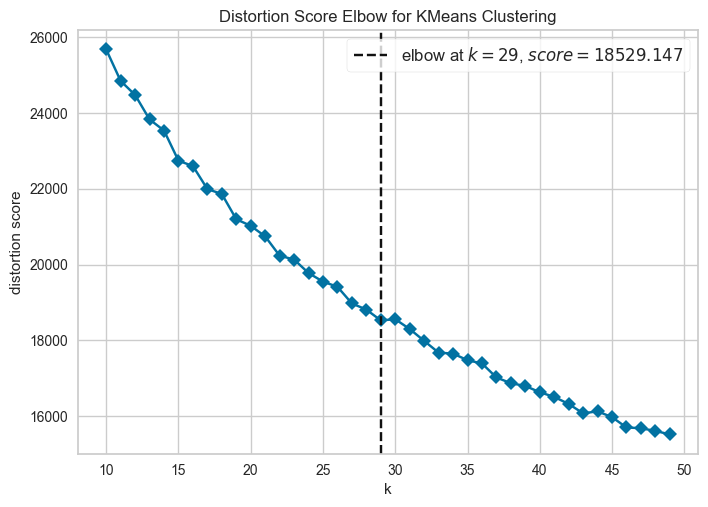

optimal number of k = 29, number_features = 38
--- run time : 0.2974700133005778 min ---


<Figure size 800x550 with 0 Axes>

In [19]:
# Loop
for group_name in Groups:
    start_time = time.time()
    group_ob = mlra_groups(model_data,group_name)
    group_ob.group_specific_feature_select_func()
    group_ob.find_optimum_k()
    group_ob.best_model_kmeans()
    group_ob.write_to_excel()
    del group_ob
    print("--- run time : {} min ---".format((time.time() - start_time)/60))
    


## Combine cluster data with modeling dataset
cluster data consists of clusters, top 5 features, and top 3 ecoclassnames. we add this information to the modeling dataset

In [26]:
import os
import glob
# we need to gather all the save_data_topeco_topfeature data files

os.chdir("Cluster_Group_Datasets/") # insert file directory where Output Files is kept

#E:/ESG_analytics/Deliverable/Clustering/July2023

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv("cluster_group_model_data.csv", index=False, encoding='utf-8-sig')